In [835]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import shap
from IPython.display import display

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting

import dtreeviz
import graphviz


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [836]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [837]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')

In [838]:
#save athlete names for later indexing
athletes_fb = df_fb['NAME']
athletes_bb = df_bb['NAME']
# athlete_names

df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [839]:
# df_bb.head()

In [840]:
#Descriptive statistics of the target variable


def format_dollars(x):
    return f'{x:.2f}'
   
# Set the formatting function for float values
pd.options.display.float_format = format_dollars

# Assuming df_bb is your DataFrame
summary = df_fb['NILVAL_LONG_USD'].describe()
print(summary)

count      1263.00
mean     157562.95
std      237093.05
min       60000.00
25%       77000.00
50%      102000.00
75%      148000.00
max     5200000.00
Name: NILVAL_LONG_USD, dtype: float64


In [841]:
#Mode value
df_fb.NILVAL_LONG_USD.mode()

0   61000.00
dtype: float64

Mean ($266,379.56) is greater than  median ($145,000.00), and the 75th percentile ($288,000.00) is substantially greater than the 25th percentile ($90,000.00). This indicates that the data is positively skewed, with a longer tail on the right side of the distribution.

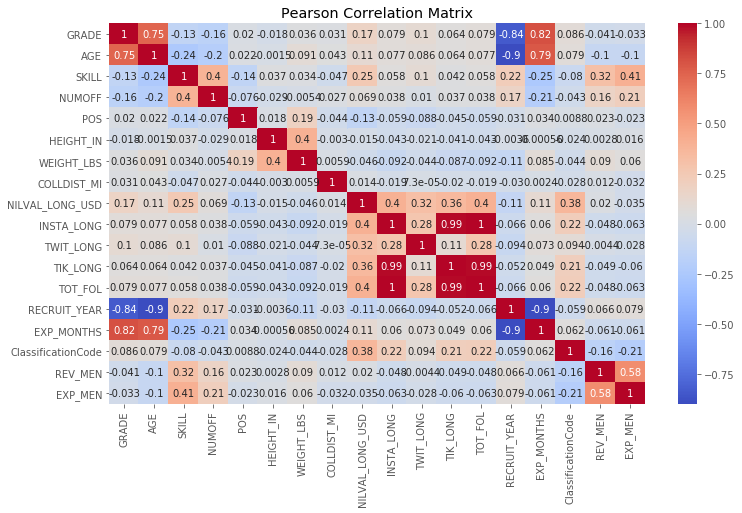

In [842]:
#Pearson Correlation matrix
plt.figure(figsize=(12,7))
plt.title('Pearson Correlation Matrix')
sns.heatmap(df_fb.corr(),annot=True, cmap = 'coolwarm')

Looking like there is some high correlation with Recruit year and other features (GRADE, EXP MONTHS) and TOT_FOL with othe social media counts

In [843]:
df_fb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [844]:
df_fb=df_fb.copy()
df_fb=df_fb.drop(columns=['RECRUIT_YEAR','TOT_FOL'])
df_fb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

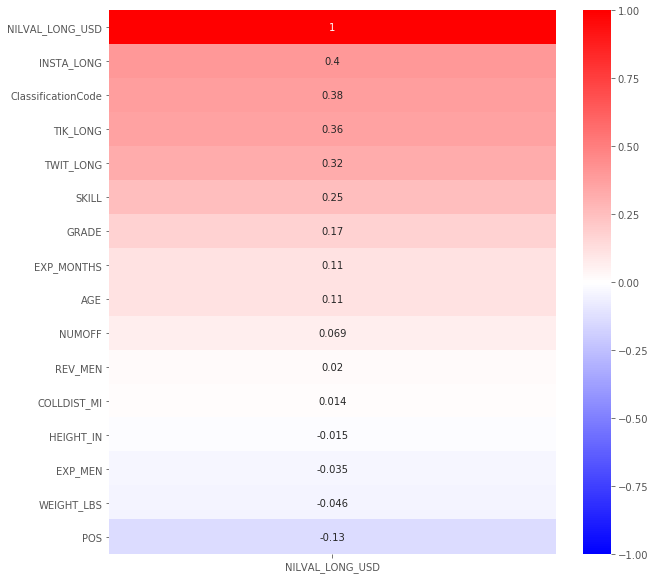

In [845]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)

corr_plot(df_fb)

In [846]:
#outliers check
def outl(x):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.boxplot(df_bb[x])
    plt.subplot(122)
    sns.distplot(df_bb[x])
    plt.tight_layout()
    plt.show()

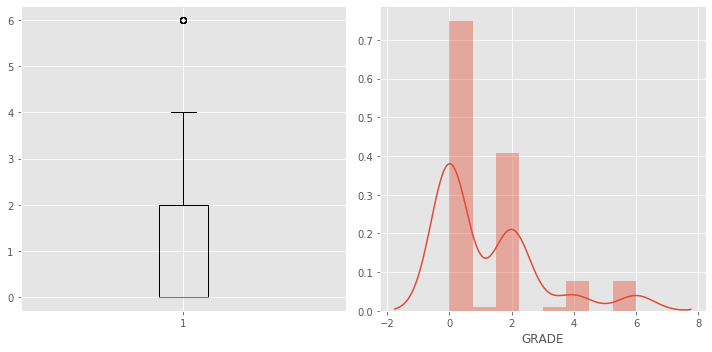

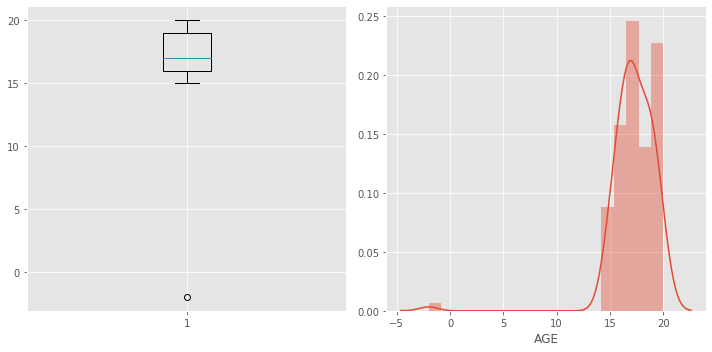

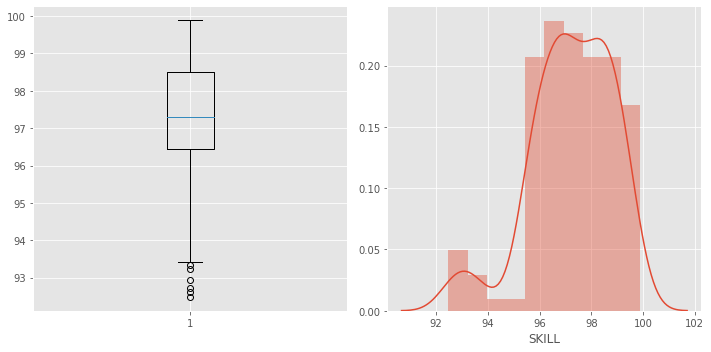

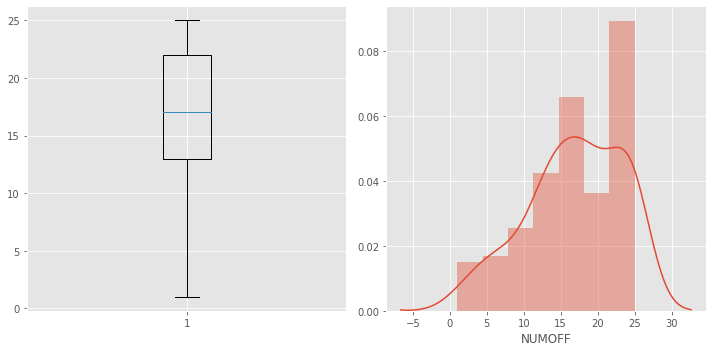

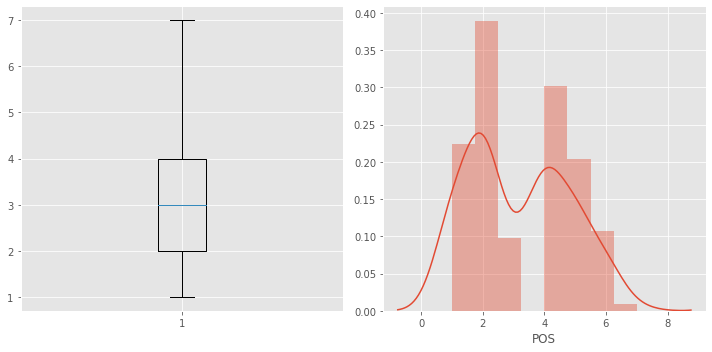

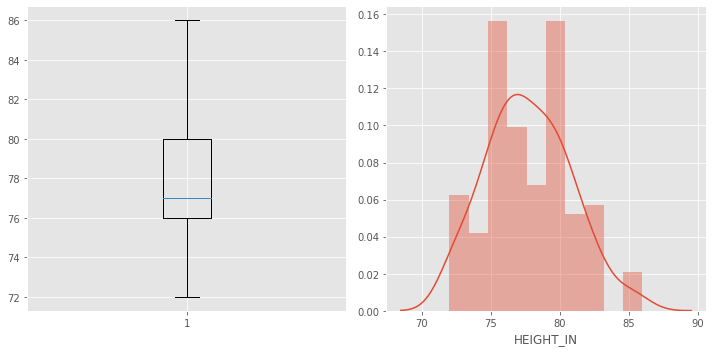

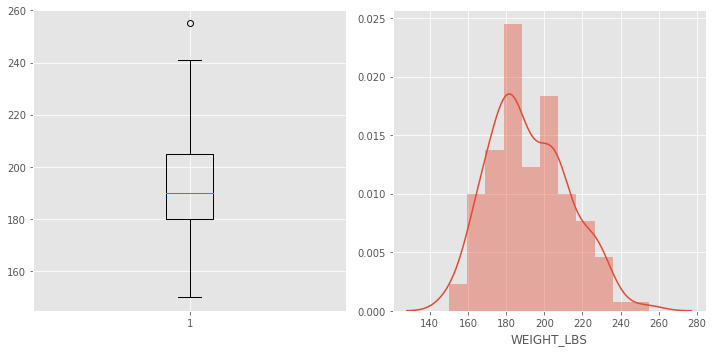

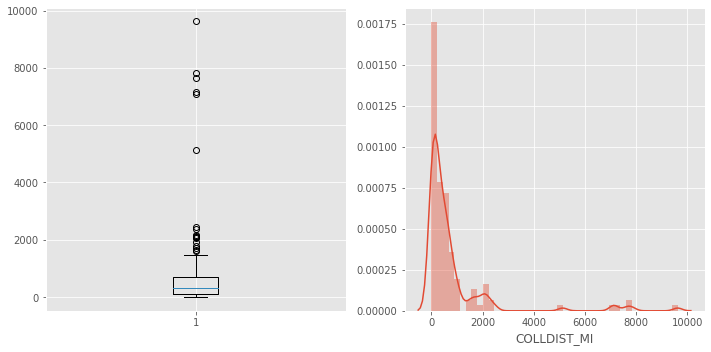

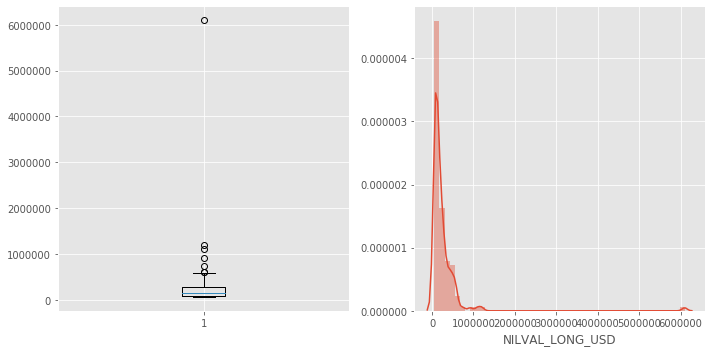

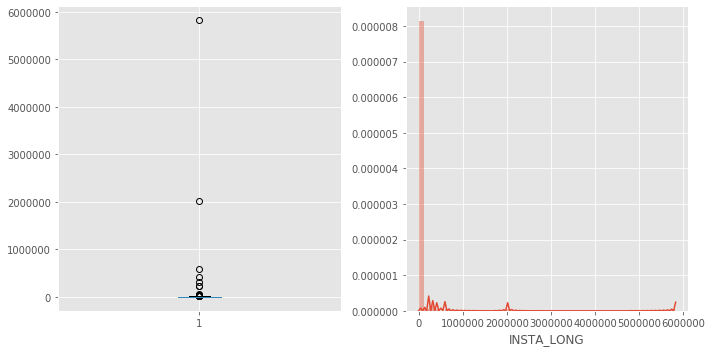

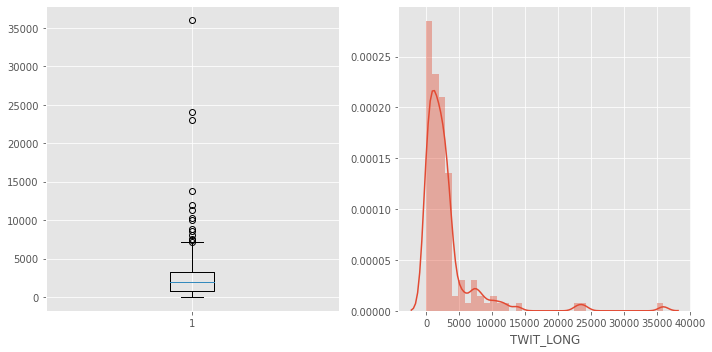

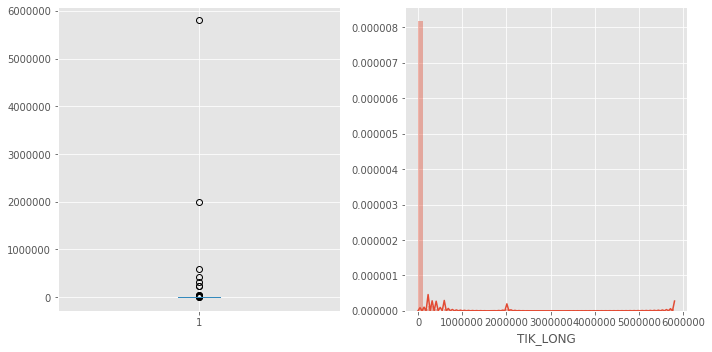

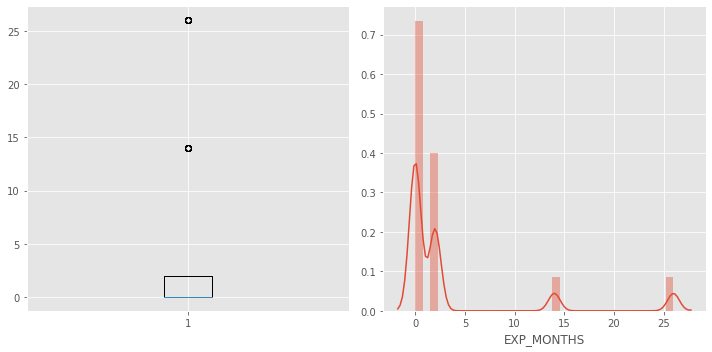

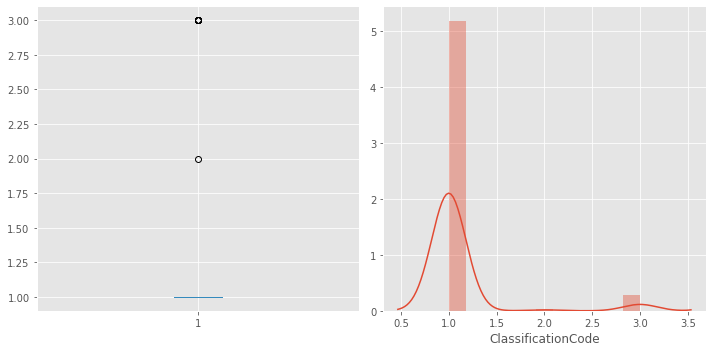

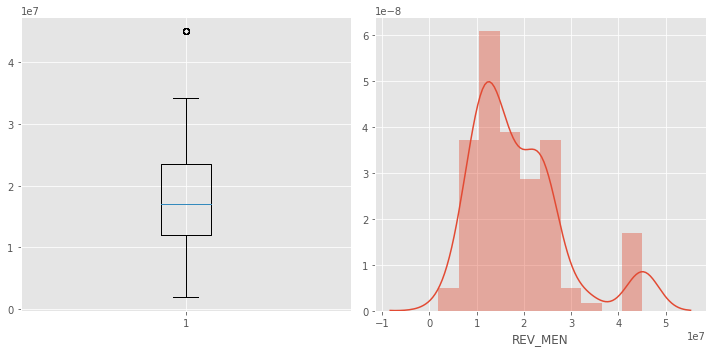

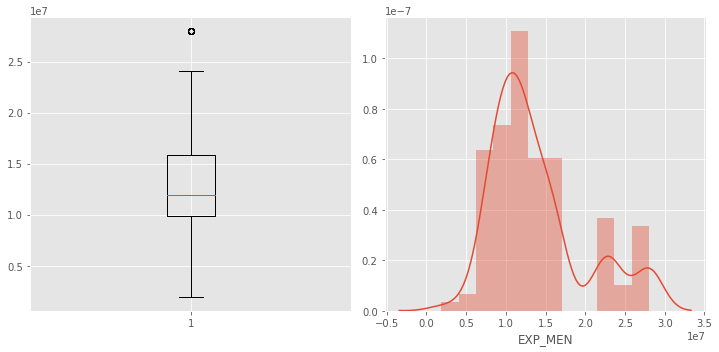

In [847]:
for col in df_fb.columns:
    outl(col)

Do outlier treatment for TIK_LONG, TWIt_LONG, INSTA_LONG, COLL_DIST

In [848]:
df_fb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [849]:
columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# Create a dictionary to store the descriptions
descriptions = {}

for col in columns:
    descriptions[col] = df_fb[col].describe()

# Display the descriptions for each column
for col, description in descriptions.items():
    print(f"Summary statistics for {col}:")
    print(description)
    print()

Summary statistics for COLLDIST_MI:
count   1263.00
mean     459.67
std      571.91
min        0.00
25%      106.00
50%      241.00
75%      639.00
max     7462.00
Name: COLLDIST_MI, dtype: float64

Summary statistics for INSTA_LONG:
count      1263.00
mean      14705.66
std       73560.22
min           0.00
25%        2380.50
50%        4109.00
75%        8353.50
max     2122000.00
Name: INSTA_LONG, dtype: float64

Summary statistics for TWIT_LONG:
count     1263.00
mean      5285.89
std      12559.44
min          0.00
25%       2000.00
50%       3300.00
75%       5650.00
max     395000.00
Name: TWIT_LONG, dtype: float64

Summary statistics for TIK_LONG:
count      1263.00
mean       9419.78
std       71134.54
min           0.00
25%           0.00
50%         107.00
75%        1600.00
max     2100000.00
Name: TIK_LONG, dtype: float64



In [850]:
columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# Create a dictionary to store the descriptions
descriptions = {}

for col in columns:
    descriptions[col] = df_fb[col].describe()

# Display the descriptions for each column
for col, description in descriptions.items():
    print(f"Summary statistics for {col}:")
    print(description)
    print()

Summary statistics for COLLDIST_MI:
count   1263.00
mean     459.67
std      571.91
min        0.00
25%      106.00
50%      241.00
75%      639.00
max     7462.00
Name: COLLDIST_MI, dtype: float64

Summary statistics for INSTA_LONG:
count      1263.00
mean      14705.66
std       73560.22
min           0.00
25%        2380.50
50%        4109.00
75%        8353.50
max     2122000.00
Name: INSTA_LONG, dtype: float64

Summary statistics for TWIT_LONG:
count     1263.00
mean      5285.89
std      12559.44
min          0.00
25%       2000.00
50%       3300.00
75%       5650.00
max     395000.00
Name: TWIT_LONG, dtype: float64

Summary statistics for TIK_LONG:
count      1263.00
mean       9419.78
std       71134.54
min           0.00
25%           0.00
50%         107.00
75%        1600.00
max     2100000.00
Name: TIK_LONG, dtype: float64



In [851]:
#using iqr method, considering both including and excluding the lower and upper limits into two separate dataframes, 
# then merging both the dataframes into one.
#goal is to filter the data to remove or cap extreme values, and then merge the resulting data back together
q1 = df_fb['INSTA_LONG'].quantile(0.25)
q2 = df_fb['INSTA_LONG'].quantile(0.50)
q3 = df_fb['INSTA_LONG'].quantile(0.75)
IQR = q3-q1

lower_limit = q1-1.5*IQR
upper_limit = q3+1.5*IQR

data_inc = df_fb.loc[(df_fb['INSTA_LONG']>=lower_limit) & (df_fb['INSTA_LONG']<=upper_limit)]
data_esc = df_fb.loc[(df_fb['INSTA_LONG']>lower_limit) & (df_fb['INSTA_LONG']<upper_limit)]
df_fb2 = pd.concat([data_inc,data_esc])
df_fb2.head()


,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN
1,2.00,18.00,97.87,25.00,8.00,73.50,225.00,207.00,497000.00,13100.00,13100.00,0.00,2.00,1.00,161532860.00,50633156.00
2,2.00,18.00,97.26,25.00,9.00,73.00,216.00,992.00,443000.00,10900.00,9200.00,1700.00,2.00,1.00,161532860.00,50633156.00
4,2.00,19.00,96.22,25.00,7.00,72.00,180.00,183.00,257000.00,16200.00,8100.00,8100.00,2.00,1.00,161532860.00,50633156.00
5,2.00,18.00,95.52,17.00,4.00,73.00,185.00,351.00,173000.00,7400.00,4400.00,3000.00,2.00,1.00,161532860.00,50633156.00
6,2.00,18.28,95.43,18.00,3.00,70.50,174.00,147.00,161000.00,5600.00,2600.00,3000.00,2.00,1.00,161532860.00,50633156.00


In [852]:
df_fb2.shape

(2224, 16)

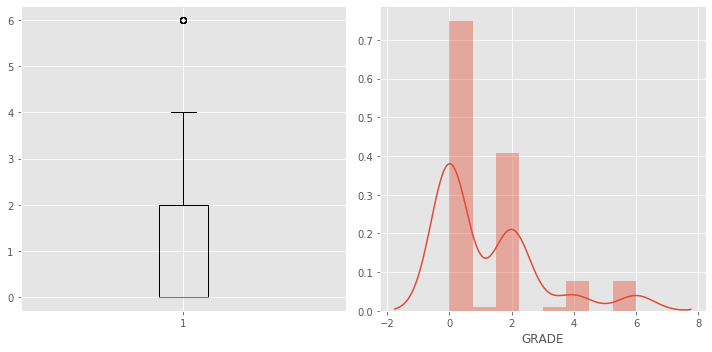

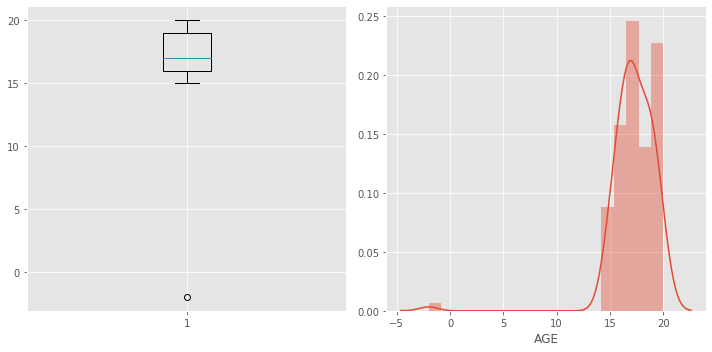

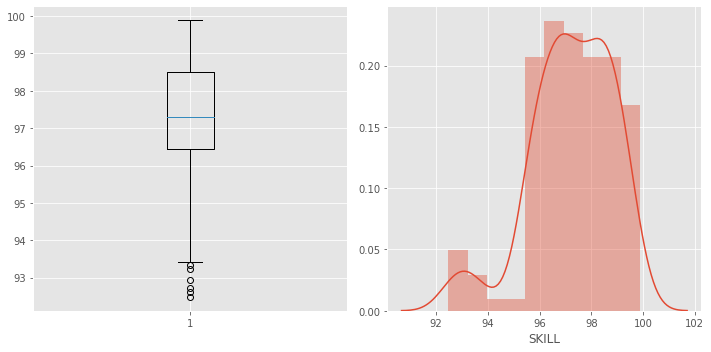

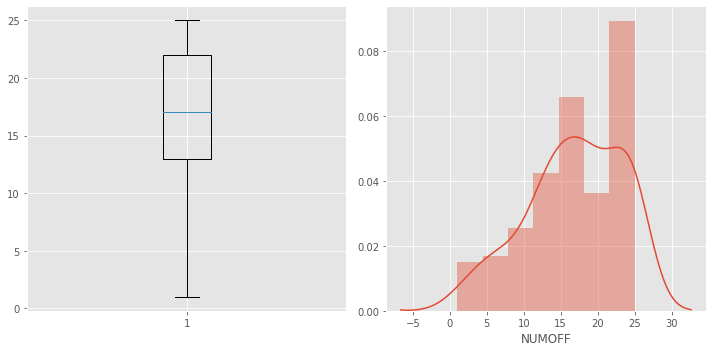

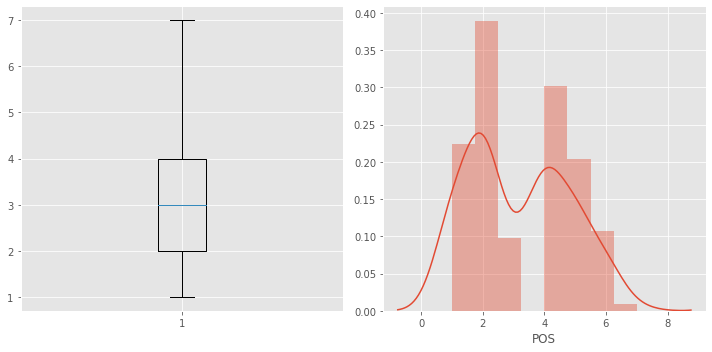

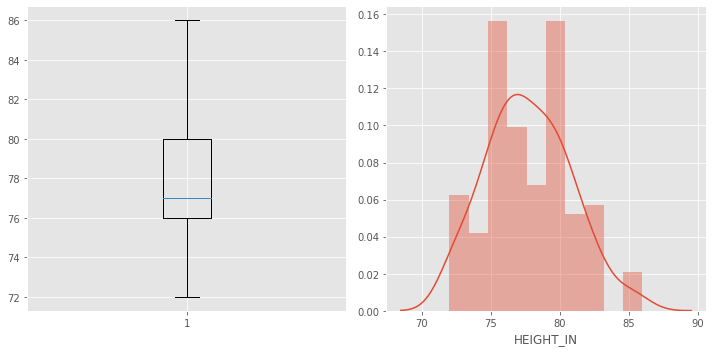

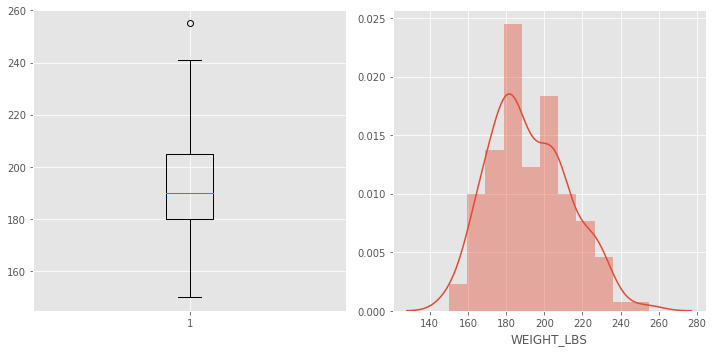

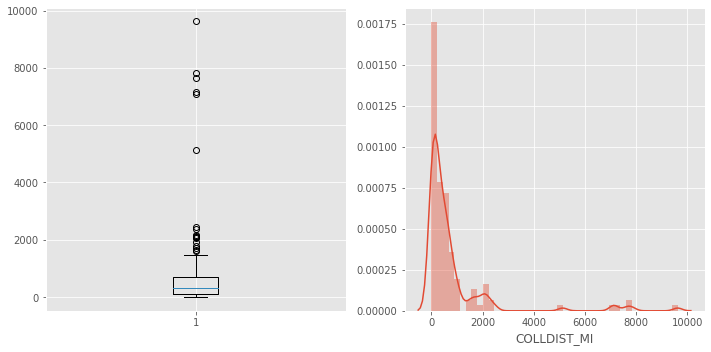

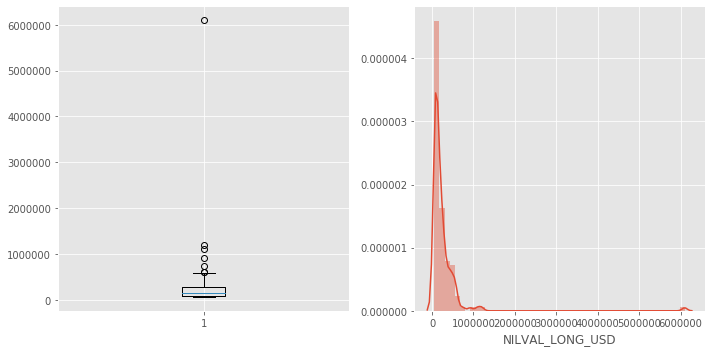

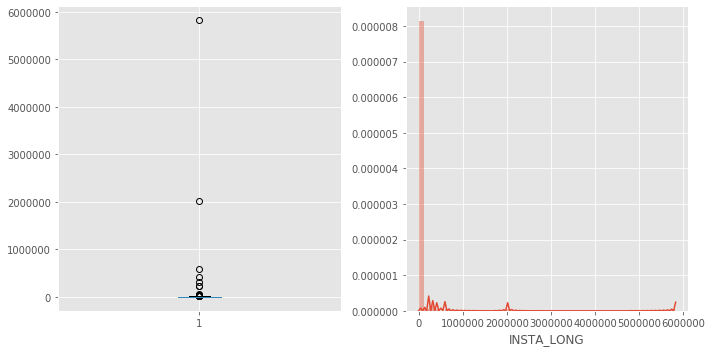

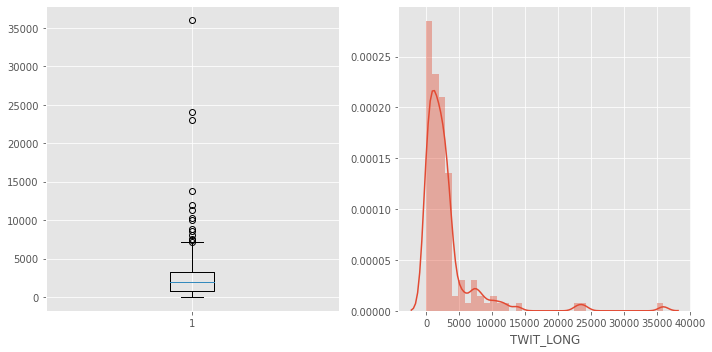

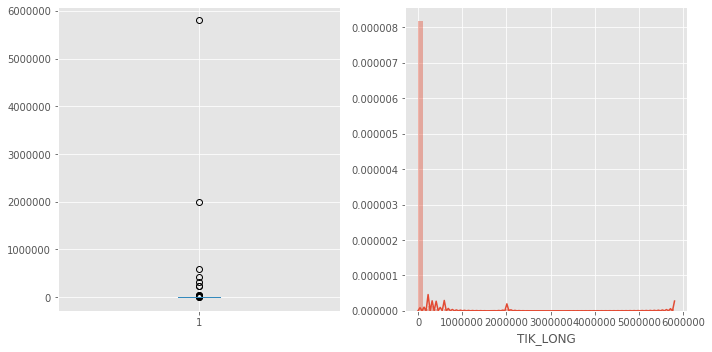

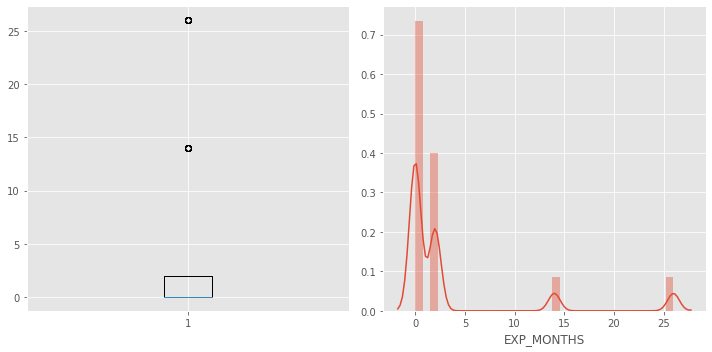

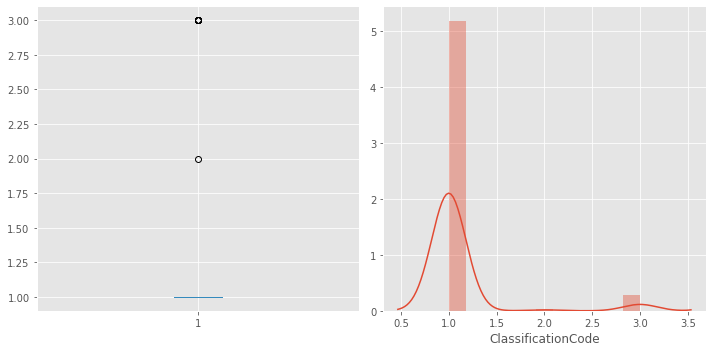

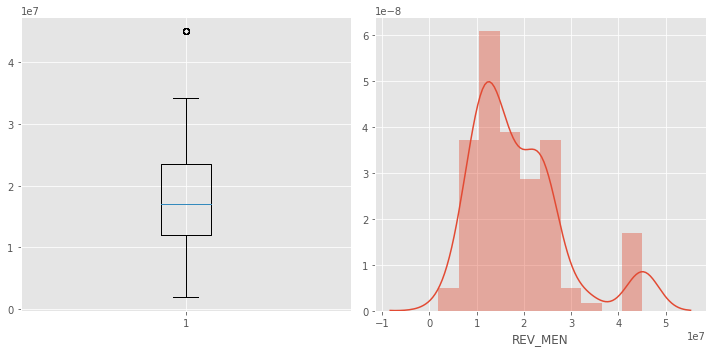

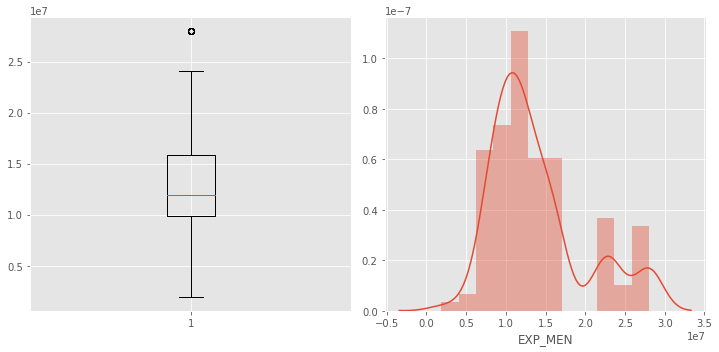

In [853]:
for col in df_fb2.columns:
    outl(col)

In [854]:
# columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# # Create a dictionary to store the descriptions
# descriptions = {}

# for col in columns:
#     descriptions[col] = df_fb2[col].describe()

# # Display the descriptions for each column
# for col, description in descriptions.items():
#     print(f"Summary statistics for {col}:")
#     print(description)
#     print()

In [855]:
# df_fb2['INSTA_LONG'].describe

**Linear Regression**

In [856]:
train_fb, test_fb = train_test_split(df_fb2, test_size=0.20, shuffle=True, random_state=42)
print('Shape for train_fb is {0}, df_test is {1}'.format(train_fb.shape,test_fb.shape))

Shape for train_fb is (1779, 16), df_test is (445, 16)


In [857]:
#Feature scaling using standard scaler

# def fscale(train,test):
    # scaler = MinMaxScaler()
    # scaler = StandardScaler()
    # train = scaler.fit_transform(train)
    # test = scaler.transform(test)
    
    # return train, test

In [858]:
# #calling  above function
# train_fb_sc,test_bb_sc = fscale(train_fb,test_bb)

In [859]:
# train_fb_sc = pd.DataFrame(train_fb_sc,columns=df_fb2.columns)
# train_fb_sc.head()

In [860]:
#Check test
# test_fb_sc = pd.DataFrame(test_fb_sc,columns=df_fb2.columns)
# test_fb_sc.head()

In [861]:
# y_trainfb_sc = train_fb_sc['NILVAL_LONG_USD']
# X_trainfb_sc = train_fb_sc.drop('NILVAL_LONG_USD',axis=1)
# y_testfb_sc = test_fb_sc['NILVAL_LONG_USD']
# X_testfb_sc = test_fb_sc.drop('NILVAL_LONG_USD',axis=1)

In [862]:
#check
# y_testfb_sc

In [863]:
# train_fb
# test_fb

y_trainfb = train_fb['NILVAL_LONG_USD']
X_trainfb = train_fb.drop('NILVAL_LONG_USD',axis=1)
y_testfb= test_fb['NILVAL_LONG_USD']
X_testfb = test_fb.drop('NILVAL_LONG_USD',axis=1)

# y_testfb

**Linear Regression - All Features**

In [864]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [865]:
lr = LinearRegression()

lr.fit(X_trainfb, y_trainfb)
y_pred_trainfb_lr = lr.predict(X_trainfb)
y_pred_testfb_lr = lr.predict(X_testfb)

print('R2 score of train data is ',r2_score(y_trainfb,y_pred_trainfb_lr))
print('rmse score of train data is ',rmse(y_trainfb,y_pred_trainfb_lr))
print('mae score of train data is ',mae(y_trainfb,y_pred_trainfb_lr))
print()
print('R2 score of test data is ',r2_score(y_testfb,y_pred_testfb_lr))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_testfb,y_testfb,y_pred_testfb_lr))
print('rmse score of test data is ',rmse(y_testfb,y_pred_testfb_lr))
print('mae score of test data is ',mae(y_testfb,y_pred_testfb_lr))

R2 score of train data is  0.17714685603560698
rmse score of train data is  95433.16135764576
mae score of train data is  54313.36984253772

R2 score of test data is  0.23945326592681992
Adj. R2 score of test data is  0.21286072277740808
rmse score of test data is  98817.20514988844
mae score of test data is  54275.376450940195


**Feature selection using RFE ( Recursive Feature Elimination)**

In [866]:
#features/ nof(number of features)
       

features = X_trainfb.columns.tolist()
nof_list = np.arange(1,len(features)+1)   
high_score=0

#Variable to store the optimum features-
nof=0    
score_list =[]

for n in range(len(nof_list)):
    
    lr = LinearRegression()
    rfe = RFE(lr,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_trainfb,y_trainfb)
    X_test_rfe = rfe.transform(X_testfb)
    lr.fit(X_train_rfe,y_trainfb)
    score = lr.score(X_test_rfe,y_testfb)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 15
Score with 15 features: 0.239453


In [867]:
#RFE with 15 features
lr = LinearRegression()
rfe = RFE(lr,15)
X_trainfb_rfe = rfe.fit_transform(X_trainfb,y_trainfb)
X_testfb_rfe = rfe.transform(X_testfb)

#Fitting the data to model
lr.fit(X_trainfb_rfe,y_trainfb)              
temp = pd.Series(rfe.support_,index = features)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')


In [868]:
#predictions
y_pred_trainfb_rfe = lr.predict(X_trainfb_rfe)
y_pred_testfb_rfe = lr.predict(X_testfb_rfe)

In [869]:
print('R2 score of train data is ',r2_score(y_trainfb,y_pred_trainfb_rfe))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainfb_rfe,y_trainfb,y_pred_trainfb_rfe))
print('rmse score of train data is ',rmse(y_trainfb, y_pred_trainfb_rfe))
print('mae score of train data is ',mae(y_trainfb, y_pred_trainfb_rfe))
print()
print('R2 score of test data is ',r2_score(y_testfb, y_pred_testfb_rfe))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_test_rfe,y_testfb,y_pred_testfb_rfe))
print('rmse score of test data is ',rmse(y_testfb, y_pred_testfb_rfe))
print('mae score of test data is ',mae(y_testfb, y_pred_testfb_rfe))



R2 score of train data is  0.17714685603560698
Adj. R2 score of train data is  0.1701458366598464
rmse score of train data is  95433.16135764576
mae score of train data is  54313.36984253772

R2 score of test data is  0.23945326592681992
Adj. R2 score of test data is  0.21286072277740808
rmse score of test data is  98817.20514988844
mae score of test data is  54275.376450940195


In [870]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#cross validation 
# Fit RFE to your data
X_trainfb_rfe = rfe.fit_transform(X_trainfb, y_trainfb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}


# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainfb_rfe, y_trainfb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 Score:", round (mean_r2_cv,3))
print("Mean RMSE Score:", round (mean_rmse_cv,3))
print("Mean MAE Score:", round (mean_mae_cv,3))

#return DF
meancv_scores_dict = { "Model" : 'Linear Regression RFE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)



Mean R2 Score: 0.108
Mean RMSE Score: 94766.044
Mean MAE Score: 54959.239


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression RFE,0.11,94766.04,54959.24


In [871]:
results = pd.DataFrame(columns = ['Algorithm',
                                  'Train_R2 score',
                                  'Train_Adj_R2 score',
                                  'Train_RMSE score',
                                  'Train_MAE score',
                                  'Test_R2 score',
                                  'Test_Adj_R2 score',
                                  'Test_RMSE score',
                                  'Test_MAE score', 
                                #   'Mean CV R2 Score',
                                #   'Mean RMSE CV Score',
                                #   'Mean MAE CV Score'

]) 
new_RFE= ['Linear Regression_RFE',
                             r2_score(y_trainfb, y_pred_trainfb_rfe),
                             adjusted_r2_score(X_train_rfe, y_trainfb, y_pred_trainfb_rfe),
                             rmse(y_trainfb, y_pred_trainfb_rfe),
                             mae(y_trainfb, y_pred_trainfb_rfe),
                             r2_score(y_testfb, y_pred_testfb_rfe),
                             adjusted_r2_score(X_test_rfe, y_testfb, y_pred_testfb_rfe),
                             rmse(y_testfb, y_pred_testfb_rfe),
                             mae(y_testfb, y_pred_testfb_rfe),
                            #  mean_r2_cv,
                            #  mean_mae_cv,
                            #  mean_rmse_cv
                             
                             
                             
                             ]
results.loc[len(results)] = new_RFE
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.18,0.17,95433.16,54313.37,0.24,0.21,98817.21,54275.38


**Feature Selection- Backward Elimination**
<br> Start with all features. Iteratively remove  worst performing features one by one unitl the overall model performance comes in acceptable range. p-value is performance metric.If p-value is above 0.05, then feature is removed; else keep feature

In [872]:
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

#Importing statsmodels
import statsmodels.api as sm
#Function for model building and fitting
def lr_sm(X_train,y_train):
    X_train_const = sm.add_constant(X_train)
    lr = sm.OLS(y_train,X_train_const).fit()
    return lr

In [873]:
#call function
lr_sm = lr_sm(X_trainfb,y_trainfb)





In [874]:
lr_sm.pvalues

const                0.00
GRADE                0.00
AGE                  0.11
SKILL                0.00
NUMOFF               0.33
POS                  0.22
HEIGHT_IN            0.45
WEIGHT_LBS           0.65
COLLDIST_MI          0.75
INSTA_LONG           0.00
TWIT_LONG            0.00
TIK_LONG             0.04
EXP_MONTHS           0.40
ClassificationCode   0.19
REV_MEN              0.01
EXP_MEN              0.00
dtype: float64

In [875]:
significance_level = 0.05

# Filter the features with p-values above the threshold
significant_features = lr_sm.pvalues[lr_sm.pvalues <= significance_level].index

# List of features to keep (those with p-values less than or equal to 0.05)
features_to_keep = list(significant_features)

# List of features to potentially eliminate (those with p-values greater than 0.10)
features_to_eliminate = list(lr_sm.pvalues[lr_sm.pvalues > significance_level].index)

# Print the significant features and features to eliminate
print("Significant Features:")
print(features_to_keep)
print("\nFeatures to Potentially Eliminate:")
print(features_to_eliminate)

Significant Features:
['const', 'GRADE', 'SKILL', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'REV_MEN', 'EXP_MEN']

Features to Potentially Eliminate:
['AGE', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS', 'COLLDIST_MI', 'EXP_MONTHS', 'ClassificationCode']


In [876]:
#Backward Elimination 
cols = list(X_trainfb.columns)
pmax = 1  #placeholder 
while (len(cols)>0):
    p= []
    X_1 = X_trainfb[cols]
    X_1 = sm.add_constant(X_1)
    lr = sm.OLS(y_trainfb,X_1).fit()
    p = pd.Series(lr.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['GRADE', 'SKILL', 'TWIT_LONG', 'REV_MEN', 'EXP_MEN']


In [877]:
#get selected features
X_trainfb_be = X_trainfb[selected_features_BE]
X_testfb_be = X_testfb[selected_features_BE]

#building a linear regression model
lr = LinearRegression()

#fitting
lr.fit(X_trainfb_be,y_trainfb)

#predictions
y_pred_trainfb_be = lr.predict(X_trainfb_be)
y_pred_testfb_be = lr.predict(X_testfb_be)

In [878]:
#Evaluation 
print('R2 score of train data is ',r2_score(y_trainfb ,y_pred_trainfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainfb_be,y_trainfb,y_pred_trainfb_be))
print('rmse score of train data is ',rmse(y_trainfb ,y_pred_trainfb_be))
print('mae score of train data is ',mae(y_trainfb,y_pred_trainfb_be))
print()
print('R2 score of test data is ',r2_score(y_testfb,y_pred_testfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_testfb_be,y_testfb,y_pred_testfb_be))
print('rmse score of test data is ',rmse(y_testfb ,y_pred_testfb_be))
print('mae score of test data is ',mae(y_testfb,y_pred_testfb_be))

new_be= ['Linear Regression_BE',
                             r2_score(y_trainfb,y_pred_trainfb_be),
                             adjusted_r2_score(X_trainfb_be,y_trainfb ,y_pred_trainfb_be),
                             rmse(y_trainfb,y_pred_trainfb_be),
                             mae(y_trainfb,y_pred_trainfb_be),
                             r2_score(y_testfb,y_pred_testfb_be),
                             adjusted_r2_score(X_testfb_be,y_testfb,y_pred_testfb_be),
                             rmse(y_testfb,y_pred_testfb_be),
                             mae(y_testfb,y_pred_testfb_be)
                             ]

results.loc[len(results)] = new_be
results

R2 score of train data is  0.17316937752180894
Adj. R2 score of train data is  0.1708376498780464
rmse score of train data is  95663.53402665045
mae score of train data is  54232.84793662857

R2 score of test data is  0.2375984511656637
Adj. R2 score of train data is  0.22891506222677604
rmse score of test data is  98937.62904270405
mae score of test data is  54215.18977265254


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.18,0.17,95433.16,54313.37,0.24,0.21,98817.21,54275.38
1,Linear Regression_BE,0.17,0.17,95663.53,54232.85,0.24,0.23,98937.63,54215.19


In [879]:
#cross validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


#cross validation 
# Fit RFE to your data
#fitting
lr.fit(X_trainfb_be,y_trainfb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainfb_be, y_trainfb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 CV Score:", round (mean_r2_cv,3))
print("Mean RMSE CV  Score:", round (mean_rmse_cv,3))
print("Mean MAE CV  Score:", round (mean_mae_cv,3))

#return DF
meancv_scores_dict = { "Model" : 'Linear Regression BE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)


Mean R2 CV Score: 0.112
Mean RMSE CV  Score: 94565.7
Mean MAE CV  Score: 54590.969


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression BE,0.11,94565.70,54590.97


**Residual Analysis**


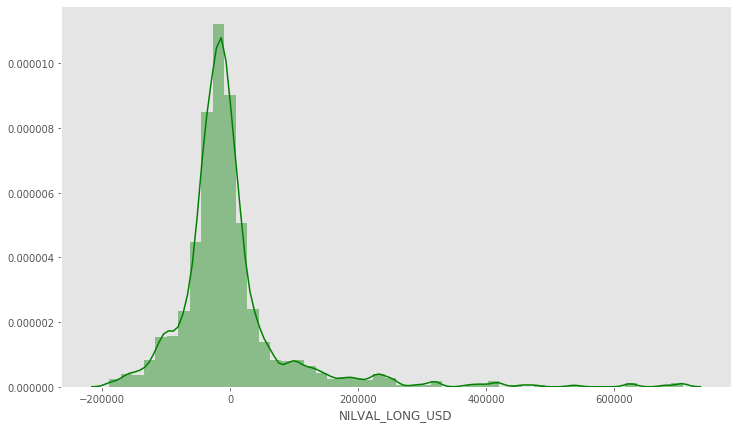

In [880]:
#check how error terms are distributed on train data for Linear Reg RFE
y_res = y_trainfb - y_pred_trainfb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

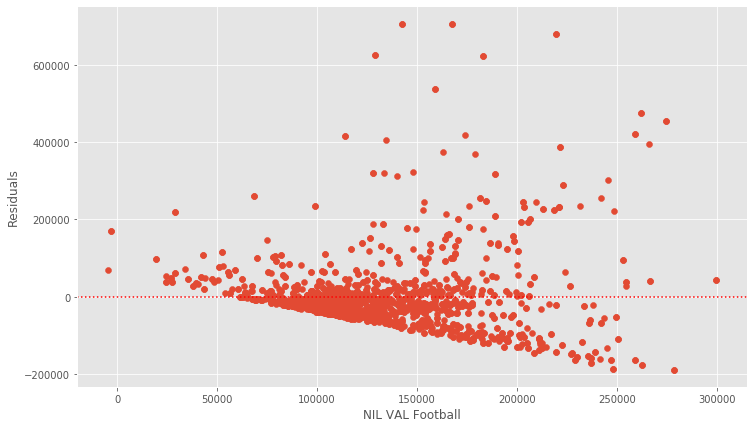

In [881]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_trainfb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Football")
plt.ylabel("Residuals")
plt.show()

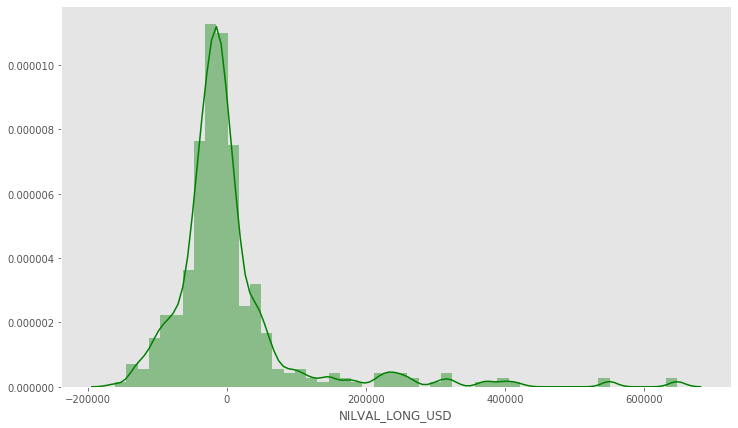

In [882]:
# error terms  distributed on test data
y_res = y_testfb - y_pred_testfb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

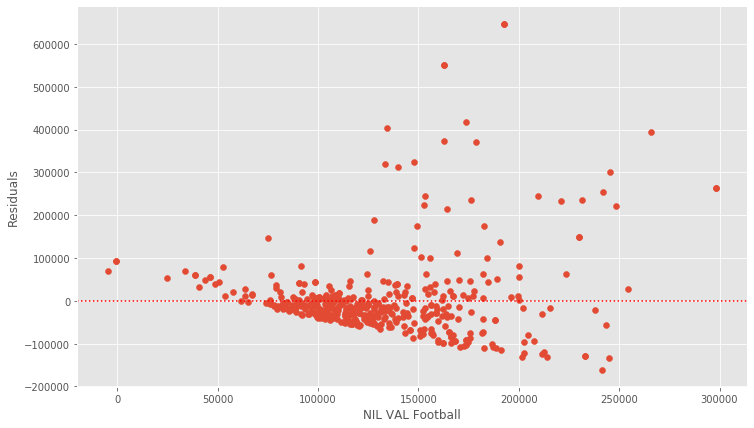

In [883]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_testfb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Football")
plt.ylabel("Residuals")
plt.show()

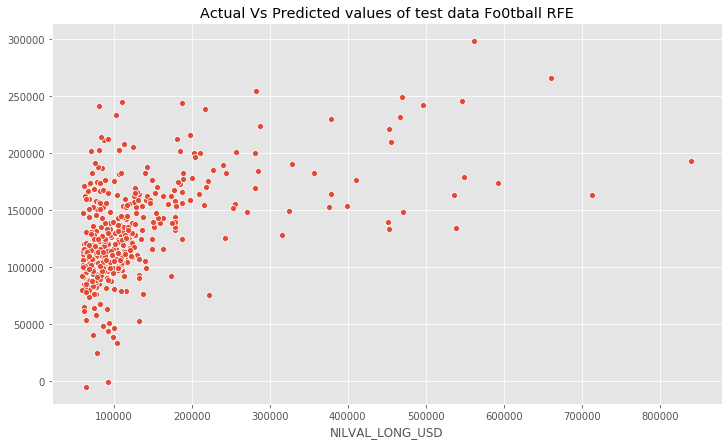

In [884]:
#actual test values vs predicted test values
plt.figure(figsize=(12,7))
plt.title('Actual Vs Predicted values of test data Fo0tball RFE')
sns.scatterplot(y_testfb,y_pred_testfb_rfe)
plt.show()

**Random Forest Regressor**

In [885]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [886]:
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

In [887]:
#randomized search cv
rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainfb,y_trainfb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [888]:
# best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 80,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_depth': 20,
 'criterion': 'mse'}

In [889]:
# best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [890]:
#Best score
rcv.best_score_

0.5655375353398611

In [891]:
#Building randomforest regressor with the best estimator 
rf1 = rcv.best_estimator_
#fitting
rf1.fit(X_trainfb,y_trainfb)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [892]:
#feature importances
rf1.feature_importances_
rf1_feature_imp = pd.DataFrame(rf1.feature_importances_, index = X_trainfb.columns, columns = ['Feature_importance'])
rf1_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
rf1_feature_imp

,Feature_importance
SKILL,0.41
INSTA_LONG,0.08
GRADE,0.07
POS,0.06
TWIT_LONG,0.05
REV_MEN,0.05
COLLDIST_MI,0.04
EXP_MONTHS,0.04
WEIGHT_LBS,0.04
TIK_LONG,0.04


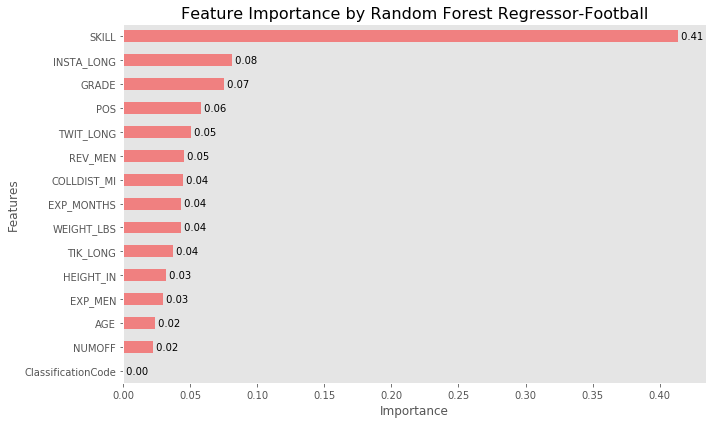

In [893]:
# Feature Visualization

rf1_feature_imp_sorted = rf1_feature_imp.sort_values(by='Feature_importance', ascending=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'lightcoral' for x in rf1_feature_imp_sorted['Feature_importance']]
rf1_feature_imp_sorted['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by Random Forest Regressor-Football', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(rf1_feature_imp_sorted.index, fontsize=10)
plt.grid (False)

# Add importance scores at the end of the bars
for i, v in enumerate(rf1_feature_imp_sorted['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )


# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [894]:
from sklearn.feature_selection import SelectFromModel

#Building randomforest regressor with the best estimator 
rf1 = rcv.best_estimator_

#fitting
rf1.fit(X_trainfb,y_trainfb)


# Create an array of threshold values to test
thresholds = [0.04, 0.05, 0.1, 0.15]

# Loop through each threshold value
for threshold in thresholds:
    # Create a SelectFromModel object with the current threshold
    sfm = SelectFromModel(rf1, threshold=threshold)
    
    # Fit SelectFromModel to the training data
    sfm.fit(X_trainfb, y_trainfb)
    
    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Count the number of selected features
    num_selected_features = sum(selected_mask)
    
    print(f"Threshold: {threshold}, Number of Selected Features: {num_selected_features}")

    # Train a new Random Forest model with the selected features
    X_train_selected = sfm.transform(X_trainfb)
    X_test_selected = sfm.transform(X_testfb)
    
    # Create a new Random Forest Regressor with the selected features
    rf_sel = RandomForestRegressor(n_estimators=80, random_state=42)
    
    # Fit the model using the selected features
    rf_sel.fit(X_train_selected, y_trainfb)

    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Print the threshold and the indices of selected features
    selected_feature_indices = [i for i, is_selected in enumerate(selected_mask) if is_selected]
    print(f"Threshold: {threshold}")
    print(f"Selected Feature Indices: {selected_feature_indices}")
    
    # Make predictions on the test set
    y_pred = rf_sel.predict(X_test_selected)
    
    # Evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(y_testfb, y_pred))
    mae = mean_absolute_error(y_testfb, y_pred)
    r2 = r2_score(y_testfb, y_pred)
    
    print(f"RMSE for Threshold {threshold}: {rmse}")
    print(f"MAE for Threshold {threshold}: {mae}")
    print(f"R-squared (R2) for Threshold {threshold}: {r2}")
  


Threshold: 0.04, Number of Selected Features: 9
Threshold: 0.04
Selected Feature Indices: [0, 2, 4, 6, 7, 8, 9, 11, 13]
RMSE for Threshold 0.04: 65012.61387439286
MAE for Threshold 0.04: 22526.404494382023
R-squared (R2) for Threshold 0.04: 0.6708028796453798
Threshold: 0.05, Number of Selected Features: 6
Threshold: 0.05
Selected Feature Indices: [0, 2, 4, 7, 8, 9]
RMSE for Threshold 0.05: 64383.04265784604
MAE for Threshold 0.05: 23330.786516853932
R-squared (R2) for Threshold 0.05: 0.6771477877334264
Threshold: 0.1, Number of Selected Features: 1
Threshold: 0.1
Selected Feature Indices: [2]
RMSE for Threshold 0.1: 95459.15193390571
MAE for Threshold 0.1: 42587.335887476285
R-squared (R2) for Threshold 0.1: 0.29026550095062553
Threshold: 0.15, Number of Selected Features: 1
Threshold: 0.15
Selected Feature Indices: [2]
RMSE for Threshold 0.15: 95459.15193390571
MAE for Threshold 0.15: 42587.335887476285
R-squared (R2) for Threshold 0.15: 0.29026550095062553


In [895]:
#consider top 12 features
# print("Indices of Features in X_trainfb:")
# print(list(X_trainfb.columns))

feature_names = X_trainfb.columns
sel_feat_indices = [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 14]
# Create a list of selected feature names based on selected_feature_indices
selected_feature_names = feature_names[sel_feat_indices]

# Print the names of the selected features
print("Selected Feature Names:")
print(selected_feature_names)

#Considering only the above features
X_trainfb_rf = X_trainfb[selected_feature_names]
X_testfb_rf = X_testfb[selected_feature_names]




Selected Feature Names:
Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'INSTA_LONG', 'TWIT_LONG', 'EXP_MONTHS', 'REV_MEN', 'EXP_MEN'],
      dtype='object')


In [896]:
#instantiating random forest regressor
rf2 = RandomForestRegressor()

#using Randomized Search CV for hyper parameter tuning
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

rcv = RandomizedSearchCV(estimator = rf2, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainfb_rf,y_trainfb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [897]:
#best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 80,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_depth': 20,
 'criterion': 'mse'}

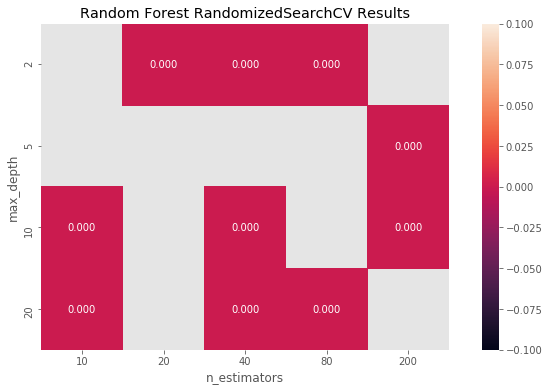

In [898]:
rcv_rf_results = rcv.cv_results_
# print (rcv_rf_results['param_n_estimators'])

param_n_estimators = None
param_max_depth = None
mean_test_score = None
try:
    param_n_estimators = rcv_rf_results['param_n_estimators']
    param_max_depth = rcv_rf_results['param_max_depth']
    mean_test_score = rcv_rf_results['mean_test_score']
except (ValueError, TypeError):
    # Handle data type conversion errors here
    print("Data type conversion error occurred.")

# Create a pivot table for heatmap
data = pd.DataFrame({'n_estimators': param_n_estimators, 'max_depth': param_max_depth, 'Mean R-squared': mean_test_score})

# Check if the 'n_estimators' column contains "?" or other invalid values
data['n_estimators']= data['n_estimators'].astype(int)
data['max_depth'] = data['max_depth'].astype(int)
data['Mean R-squared'] = data['Mean R-squared'].astype(int)


# # Create the pivot table

plt.figure(figsize=(12, 6))
sns.heatmap(data.pivot_table(index='max_depth', columns='n_estimators', values='Mean R-squared'),
            annot=True, fmt=".3f", cbar=True, square=True)
plt.title('Random Forest RandomizedSearchCV Results')
plt.show()



In [899]:
#best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [900]:
#best score
rcv.best_score_

0.5533562155106819

In [901]:
# # rebuilding the random forest regressor using the best estimator suggested by 
# #the Randomized Search CV and selected features
rf2 = rcv.best_estimator_

#fitting on the training data
rf2= rf2.fit(X_trainfb_rf,y_trainfb)

In [902]:
# Define the rmse function

#predictions on train data
y_pred_train = rf2.predict(X_trainfb_rf)

#predictions on test data
y_pred_test = rf2.predict(X_testfb_rf)

r2_train = r2_score(y_trainfb,y_pred_train)
adj_r2_train = adjusted_r2_score(X_trainfb_rf,y_trainfb,y_pred_train)
# rmse_train = rmse(y_trainfb,y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_trainfb, y_pred_train))

# mae_train = mae(y_trainfb,y_pred_train)
mae_train= mean_absolute_error(y_trainfb, y_pred_train)

r2_test = r2_score(y_testfb,y_pred_test)
adj_r2_test = adjusted_r2_score(X_testfb_rf,y_testfb,y_pred_test)
# rmse_test = rmse(y_testfb,y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_testfb, y_pred_test))
# mae_test = mae(y_testfb,y_pred_test)
mae_test = mean_absolute_error(y_testfb, y_pred_test)


In [903]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train )
print('mae score of train data is ', mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ',rmse_test)
print('mae score of test data is ', mae_test)




R2 score of train data is  0.8021850381482717
Adj. R2 score of train data is  0.8008408821220991
rmse score of train data is  46791.58026056137
mae score of train data is  19153.340202514766

R2 score of test data is  0.5485203935469196
Adj. R2 score of train data is  0.5359792933676674
rmse score of test data is  76135.75917663633
mae score of test data is  30906.044580528847


In [904]:
#Updating the results
new_RFE = ['Random Forest regressor select',
                             r2_train,
                             adj_r2_train,
                             rmse_train,
                             mae_train,
                             r2_test,
                             adj_r2_test,
                             rmse_test,
                             mae_test,
                             ]

results.loc[len(results)] = new_RFE
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.18,0.17,95433.16,54313.37,0.24,0.21,98817.21,54275.38
1,Linear Regression_BE,0.17,0.17,95663.53,54232.85,0.24,0.23,98937.63,54215.19
2,Random Forest regressor select,0.80,0.80,46791.58,19153.34,0.55,0.54,76135.76,30906.04


**Sensitivity Analysis Random Forest Regressor**

In [905]:
# df_fb2.shape
df_fb2.columns


Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

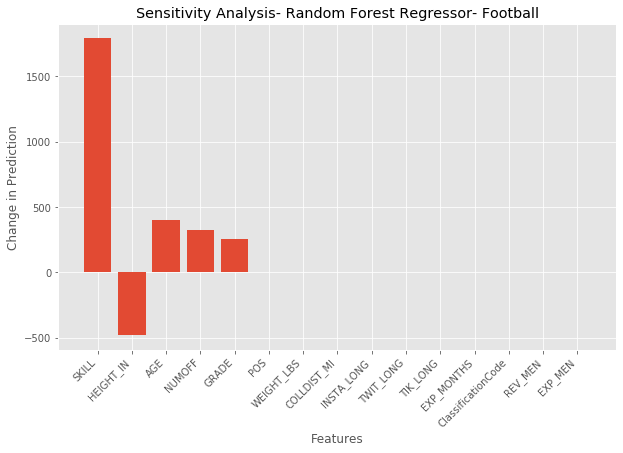

In [906]:
# Train the initial Random Forest model (RF1) using X_trainfb and y_trainfb
rf1.fit(X_trainfb, y_trainfb)

perturbation_value = 0.5 

# Calculate the mean feature values
mean_feature_values = X_trainfb.mean(axis=0)

# Central data point with the mean feature values
central_data_point = mean_feature_values

# Make predictions for the central data point using the initial model (RF1)
predicted_value = rf1.predict([central_data_point])[0]

# List of features to perform sensitivity analysis on
features_to_vary = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
   'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
   'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'] 

# Convert feature names to column indices
feature_indices = [X_trainfb.columns.get_loc(feature_to_vary) for feature_to_vary in features_to_vary]


# Store the results of sensitivity analysis
sensitivity_results = []

for feature_index in feature_indices:
    feature_name = features_to_vary[feature_index] 

    # Vary the feature value for sensitivity analysis
    perturbed_data_point = np.copy(central_data_point)
    perturbed_data_point[feature_index] += perturbation_value  # Adjust perturbation_value as needed

    # Make predictions for the perturbed data point
    perturbed_value = rf1.predict([perturbed_data_point])[0]

    # Calculate the change in prediction
    prediction_change = perturbed_value - predicted_value

    sensitivity_results.append((feature_name, prediction_change))

# Sort the sensitivity results by the magnitude of change
sensitivity_results.sort(key=lambda x: abs(x[1]), reverse=True)
# print(sensitivity_results)


# Plot the sensitivity results
plt.figure(figsize=(10, 6))
features, changes = zip(*sensitivity_results)
plt.bar(features, changes)
plt.xlabel("Features")
plt.ylabel("Change in Prediction")
plt.xticks(rotation=45, ha="right")  
plt.title("Sensitivity Analysis- Random Forest Regressor- Football")
plt.show()





**Feature Ablation Random Forest Regressor**

In [907]:
# Initialize variables to store feature importance and performance changes


feature_importance = rf1.feature_importances_
feature_names = X_trainfb.columns  # Replace with your feature names
ablation_mae = []
ablation_r2 = []

rf1.fit(X_trainfb, y_trainfb)
y_pred = rf1.predict(X_testfb)
baseline_mae = mean_absolute_error(y_testfb, y_pred)
baseline_r2 = r2_score(y_testfb, y_pred)

for i in range(X_trainfb.shape[1]):
    # Temporarily remove one feature at a time
    reduced_X_train = X_trainfb.drop(columns= feature_names[i])
    X_test_reduced = X_testfb.drop(columns=feature_names[i])

    # Train a new Random Forest model with one feature removed
    rf1.fit(reduced_X_train, y_trainfb)
    y_pred = rf1.predict(X_test_reduced)
    
    # Calculate MSE and R-squared for the reduced model
    mae = mean_absolute_error(y_testfb, y_pred)
    r2 = r2_score(y_testfb, y_pred)
    
    ablation_mae.append(mae)
    ablation_r2.append(r2)
    
    print(f"Removed {feature_names[i]} - Ablation MAE: {mae}, Ablation R-squared: {r2}")

# # Compare the change in performance metrics with each feature removed
for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    print(f"Removed {feature}: MAE Change: {mae_change}, R-squared Change: {r2_change}")

    # Create a list of dictionaries to store the results
ab_results = []

for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    result_dict = {
        "Feature Removed": feature,
        "MAE Change": mae_change,
        "R-squared Change": r2_change
    }
    ab_results.append(result_dict)

# Convert the list of dictionaries to a Pandas DataFrame
ablation_df = pd.DataFrame(ab_results)

# Display the DataFrame
display(ablation_df)

Removed GRADE - Ablation MAE: 30470.625622209085, Ablation R-squared: 0.5350253016694442
Removed AGE - Ablation MAE: 31295.291723400445, Ablation R-squared: 0.5537056685326018
Removed SKILL - Ablation MAE: 42328.91342391202, Ablation R-squared: 0.47620348562837966
Removed NUMOFF - Ablation MAE: 30213.181730523724, Ablation R-squared: 0.5578986906785747
Removed POS - Ablation MAE: 32521.83887203567, Ablation R-squared: 0.5237622783316929
Removed HEIGHT_IN - Ablation MAE: 30026.579212780245, Ablation R-squared: 0.5605505441621728
Removed WEIGHT_LBS - Ablation MAE: 30564.718288043878, Ablation R-squared: 0.5633134063018559
Removed COLLDIST_MI - Ablation MAE: 30349.59874084731, Ablation R-squared: 0.548485900698987
Removed INSTA_LONG - Ablation MAE: 30409.426093362934, Ablation R-squared: 0.5480862454393669
Removed TWIT_LONG - Ablation MAE: 30088.091902808475, Ablation R-squared: 0.578496158385285
Removed TIK_LONG - Ablation MAE: 30371.982368455487, Ablation R-squared: 0.5731997555189015
R

,Feature Removed,MAE Change,R-squared Change
0,GRADE,-320.59,-0.03
1,AGE,-1145.25,-0.01
2,SKILL,-12178.87,-0.08
3,NUMOFF,-63.14,-0.00
4,POS,-2371.80,-0.04
5,HEIGHT_IN,123.46,0.00
6,WEIGHT_LBS,-414.68,0.00
7,COLLDIST_MI,-199.56,-0.01
8,INSTA_LONG,-259.39,-0.01
9,TWIT_LONG,61.95,0.02


In [909]:
# Create a list of dictionaries to store the results
ab_results = []

for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    result_dict = {
        "Feature Removed": feature,
        "MAE Change": mae_change,
        "R-squared Change": r2_change
    }
    results.append(result_dict, ignore_index=True)

# Convert the list of dictionaries to a Pandas DataFrame
ablation_df = pd.DataFrame(ab_results)

# Display the DataFrame
display(ablation_df)

""


**Sensitivity Analysis**

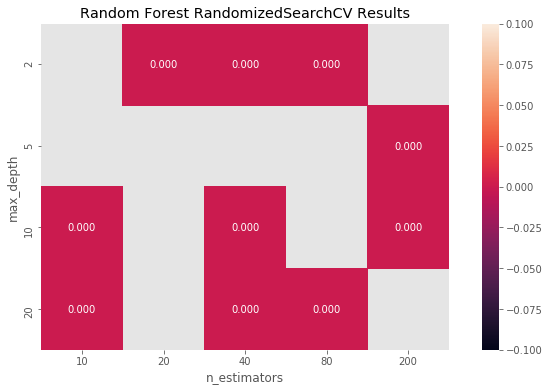

In [910]:
rcv_rf_results = rcv.cv_results_
# print (rcv_rf_results['param_n_estimators'])

param_n_estimators = None
param_max_depth = None
mean_test_score = None
try:
    param_n_estimators = rcv_rf_results['param_n_estimators']
    param_max_depth = rcv_rf_results['param_max_depth']
    mean_test_score = rcv_rf_results['mean_test_score']
except (ValueError, TypeError):
    # Handle data type conversion errors here
    print("Data type conversion error occurred.")

# Create a pivot table for heatmap
data = pd.DataFrame({'n_estimators': param_n_estimators, 'max_depth': param_max_depth, 'Mean R-squared': mean_test_score})

# Check if the 'n_estimators' column contains "?" or other invalid values
data['n_estimators']= data['n_estimators'].astype(int)
data['max_depth'] = data['max_depth'].astype(int)
data['Mean R-squared'] = data['Mean R-squared'].astype(int)


# # Create the pivot table

plt.figure(figsize=(12, 6))
sns.heatmap(data.pivot_table(index='max_depth', columns='n_estimators', values='Mean R-squared'),
            annot=True, fmt=".3f", cbar=True, square=True)
plt.title('Random Forest RandomizedSearchCV Results')
plt.show()



**XGBoost**


In [911]:
xgbr = XGBRegressor()

params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainfb,y_trainfb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [912]:
# best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [913]:
# best estimator
rcv.best_params_

{'subsample': 1,
 'reg_lambda': 200,
 'reg_alpha': 4,
 'min_child_weight': 8,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

In [914]:
#best score
rcv.best_score_

0.537801575018497

In [915]:
#Building XGboost regressor with best hyperparameters
xgbr = rcv.best_estimator_
#Fitting on train data
xgbr.fit(X_trainfb,y_trainfb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [916]:
#feature importances
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index = X_trainfb.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
xgbr_feature_imp

,Feature_importance
SKILL,0.19
EXP_MONTHS,0.15
GRADE,0.15
INSTA_LONG,0.06
POS,0.06
NUMOFF,0.05
REV_MEN,0.05
TWIT_LONG,0.05
WEIGHT_LBS,0.05
AGE,0.04


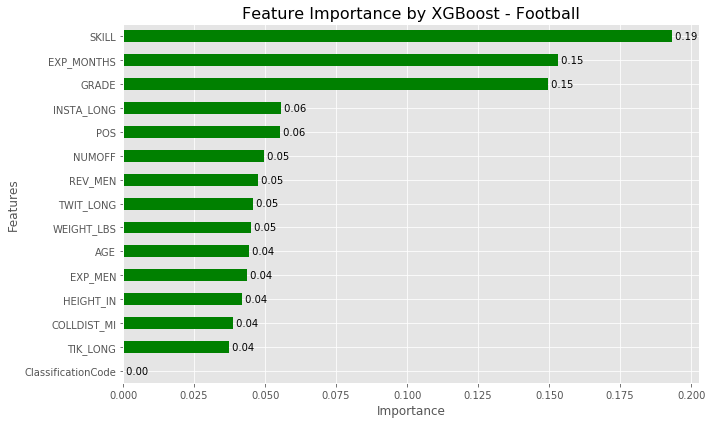

In [917]:
# Feature Visualization
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index=X_trainfb.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by='Feature_importance', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'green' for x in xgbr_feature_imp['Feature_importance']]
xgbr_feature_imp['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by XGBoost - Football', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(xgbr_feature_imp.index, fontsize=10)

# Add importance scores at the end of the bars
for i, v in enumerate(xgbr_feature_imp['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )

# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [918]:
#consider top 5 features
xgbr_top_features =  ['GRADE','SKILL',  'INSTA_LONG', 'POS']

In [919]:
X_train_xgbr2 = X_trainfb[xgbr_top_features]
X_test_xgbr2 = X_testfb[xgbr_top_features]

In [920]:
#Fitting on the training data
xgbr2 = XGBRegressor()
params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr2, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train_xgbr,y_trainfb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [921]:
#best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [922]:
#best params
rcv.best_params_

{'subsample': 1,
 'reg_lambda': 200,
 'reg_alpha': 4,
 'min_child_weight': 8,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

In [923]:
#best score
rcv.best_score_

0.3856236735750271

In [925]:
xgbr2 = rcv.best_estimator_
#fitting
xgbr2.fit(X_train_xgbr2, y_trainfb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [927]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)




# Predictions on train data
y_pred_train = xgbr2.predict(X_train_xgbr2)

# Predictions on test data
y_pred_test = xgbr2.predict(X_test_xgbr2)

r2_train = r2_score(y_trainfb, y_pred_train)
adj_r2_train = adjusted_r2_score(X_train_xgbr2, y_trainfb, y_pred_train)  # Define the adjusted_r2_score function
rmse_train = rmse(y_trainfb, y_pred_train)  # Define the rmse function
mae_train = mae(y_trainfb, y_pred_train)  # Define the mae function

r2_test = r2_score(y_testfb, y_pred_test)
adj_r2_test = adjusted_r2_score(X_test_xgbr2, y_testfb, y_pred_test)  # Define the adjusted_r2_score function
rmse_test = rmse(y_testfb, y_pred_test)  # Define the rmse function
mae_test = mae(y_testfb, y_pred_test)  # Define the mae function

print('R2 score of train data is', r2_train)
print('Adj. R2 score of train data is', adj_r2_train)
print('rmse score of train data is', rmse_train)
print('mae score of train data is', mae_train)
print()
print('R2 score of test data is', r2_test)
print('Adj. R2 score of test data is', adj_r2_test)
print('rmse score of test data is', rmse_test)
print('mae score of test data is', mae_test)

# Assuming "results" is a DataFrame
new_xgb = ['XG Boost regressor',
           r2_train,
           adj_r2_train,
           rmse_train,
           mae_train,
           r2_test,
           adj_r2_test,
           rmse_test,
           mae_test]

# Append the new_xgb to the results DataFrame
results.loc[len(results)] = new_xgb
results


R2 score of train data is 0.5796552963173405
Adj. R2 score of train data is 0.5787075066810774
rmse score of train data is 68208.8824667267
mae score of train data is 34721.61834685919

R2 score of test data is 0.43600974718829755
Adj. R2 score of test data is 0.4308825630718275
rmse score of test data is 85095.26848344869
mae score of test data is 40849.080916432584


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.18,0.17,95433.16,54313.37,0.24,0.21,98817.21,54275.38
1,Linear Regression_BE,0.17,0.17,95663.53,54232.85,0.24,0.23,98937.63,54215.19
2,Random Forest regressor select,0.80,0.80,46791.58,19153.34,0.55,0.54,76135.76,30906.04
3,XG Boost regressor,0.58,0.58,68208.88,34721.62,0.44,0.43,85095.27,40849.08


In [926]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import pandas as pd

# Define your XGBoost Regressor model
xgbr2 = rcv.best_estimator_

# Assuming X_train_xgbr and y_trainbb are your training data
# Set the number of folds (k) for cross-validation, e.g., 5-fold
k = 5

# Define custom scoring functions for MAE and RMSE
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Perform k-fold cross-validation with custom scoring functions
cv_results = cross_validate(xgbr2, X_train_xgbr2, y_trainfb, cv=k, scoring=scoring)

# Calculate mean scores
mean_r2_cv = np.mean(cv_results['test_r2'])
mean_mae_cv = np.mean(-cv_results['test_neg_mean_absolute_error'])
mean_rmse_score = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))

# Create a dictionary with the results
cv_scores_dict = {
    "Model": 'XGBoost CV',
    "Mean R2 CV Score": mean_r2_cv,
    "Mean MAE CV Score": mean_mae_cv,
    "Mean RMSE CV Score": mean_rmse_score
}

# Convert the dictionary to a Pandas DataFrame
cv_scores_df = pd.DataFrame([cv_scores_dict])

# Display the DataFrame
display(cv_scores_df)

,Model,Mean R2 CV Score,Mean MAE CV Score,Mean RMSE CV Score
0,XGBoost CV,0.40,41618.52,79817.94
